In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt 
import seaborn as sns
import osmnx as ox
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import folium
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

In [5]:
df_05 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202205-divvy-tripdata.csv')
df_06 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202206-divvy-tripdata.csv')
df_07 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202207-divvy-tripdata.csv')
df_08 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202208-divvy-tripdata.csv')
df_09 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202209-divvy-publictripdata.csv')
df_10 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202210-divvy-tripdata.csv')
df_11 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202211-divvy-tripdata.csv')
df_12 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202212-divvy-tripdata.csv')
df_01 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202301-divvy-tripdata.csv')
df_02 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202302-divvy-tripdata.csv')
df_03 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202303-divvy-tripdata.csv')
df_04 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202304-divvy-tripdata.csv')

df = pd.concat([df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12, df_01, df_02, df_03, df_04], ignore_index=True)
df = df.dropna().reset_index(drop=True)
print("Nach Entfernen der NaN-Werte:", df.shape[0])

# find all unique stations
unique_stations_start = df.groupby('end_station_id').first().reset_index()

# convert the timestamp 
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Calculate 'ride duration'
df['ride_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

# Filter of trips that take between 5 and 120 minutes
df = df[(df['ride_duration'] >= 5) & (df['ride_duration'] <= 120)]
print("Nach Filterung der Fahrdauer:", df.shape[0])

# Save of the filtered df
df_start = df

Nach Entfernen der NaN-Werte: 4533999
Nach Filterung der Fahrdauer: 3622812


In [6]:

# Calculate total trips of each station
total_trips_per_station = df_start.groupby('end_station_id')['ride_id'].count().reset_index(name='total_trips')

# Get df with all stations with less than 200 total trips and remove them
stations_to_remove = total_trips_per_station[total_trips_per_station['total_trips'] < 200]['end_station_id']
df_filtered = df_start[~df_start['end_station_id'].isin(stations_to_remove)]
unique_stations_filtered = unique_stations_start[~unique_stations_start['end_station_id'].isin(stations_to_remove)]

/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anacond

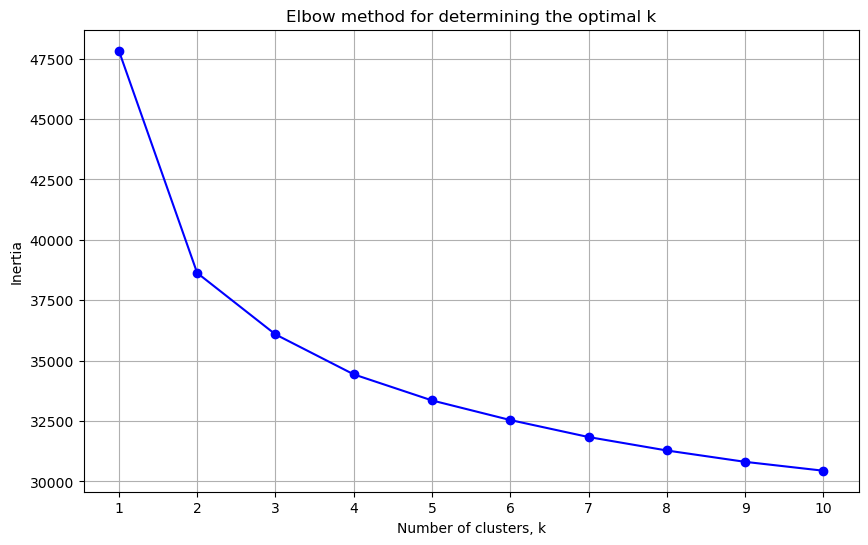

In [4]:

df = df_filtered.copy()
df['ended_at'] = pd.to_datetime(df['ended_at'])
df.loc[:, 'hour'] = df['ended_at'].dt.hour
df.loc[:, 'weekday'] = df['ended_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df = df.pivot_table(index='end_station_id', 
                        columns='weekday_hour', 
                        values='ride_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

# sort the columns in chronological order
sorted_columns = ['end_station_id'] + sorted([col for col in pivot_df.columns if col != 'end_station_id'])
pivot_df = pivot_df[sorted_columns]

#use combination of weekday and hour as feature
features = pivot_df.drop('end_station_id', axis=1)

# Initiate the scaler
scaler = StandardScaler()

# Apply the scaler row-wise and reformat the result for kmeans
scaled_features_rowwise = np.vstack(features.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1))

# Elbow method
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_rowwise)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow method for determining the optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anacond

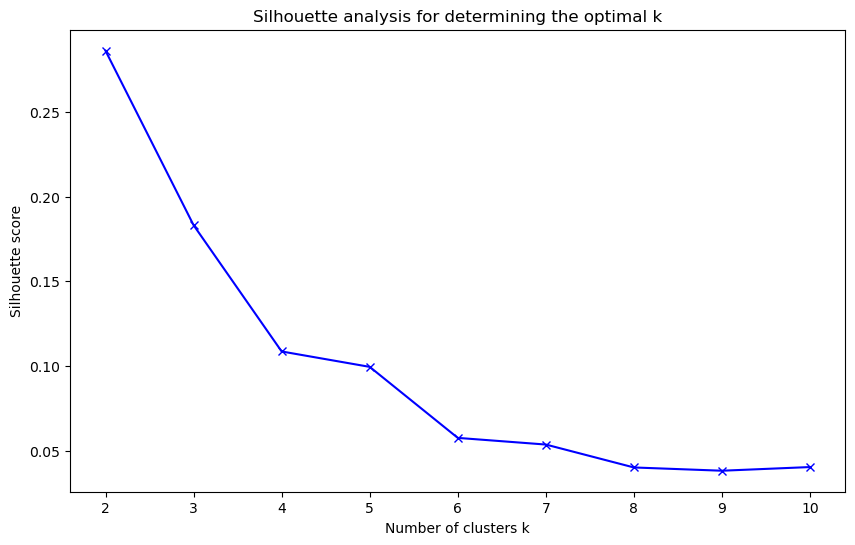

In [5]:
df = df_filtered.copy()
df['ended_at'] = pd.to_datetime(df['ended_at'])
df.loc[:, 'hour'] = df['ended_at'].dt.hour
df.loc[:, 'weekday'] = df['ended_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df = df.pivot_table(index='end_station_id', 
                        columns='weekday_hour', 
                        values='ride_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

# sort the columns in chronological order
sorted_columns = ['end_station_id'] + sorted([col for col in pivot_df.columns if col != 'end_station_id'])
pivot_df = pivot_df[sorted_columns]

#use combination of weekday and hour as feature
features = pivot_df.drop('end_station_id', axis=1)

# Initiate the scaler
scaler = StandardScaler()

# Apply the scaler row-wise and reformat the result for kmeans
scaled_features_rowwise = np.vstack(features.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1))

# silhouette
silhouette_scores = []
K = range(2, 11)  # Silhouetten-Score kann nicht mit k=1 berechnet werden
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_rowwise)
    cluster_labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(scaled_features_rowwise, cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis for determining the optimal k')
plt.show()



In [7]:
df = df_filtered.copy()
df['ended_at'] = pd.to_datetime(df['ended_at'])
df.loc[:, 'hour'] = df['ended_at'].dt.hour
df.loc[:, 'weekday'] = df['ended_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df = df.pivot_table(index='end_station_id', 
                        columns='weekday_hour', 
                        values='ride_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

# sort the columns in chronological order
sorted_columns = ['end_station_id'] + sorted([col for col in pivot_df.columns if col != 'end_station_id'])
pivot_df = pivot_df[sorted_columns]


#use combination of weekday and hour as feature
features = pivot_df.drop('end_station_id', axis=1)

# Initiate the scaler
scaler = StandardScaler()

# Apply the scaler row-wise and reformat the result for kmeans
scaled_features_rowwise = np.vstack(features.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1))

# create kmeans model 
kmeans = KMeans(n_clusters=3)  # Adjust the number of clusters as needed for your analysis
clusters = kmeans.fit_predict(scaled_features_rowwise)

# Add the cluster assignments back to the DataFrame
pivot_df['cluster'] = clusters

df = df_filtered.merge(pivot_df[['end_station_id', 'cluster']], on='end_station_id', how='left')
unique_stations = unique_stations_filtered.merge(pivot_df[['end_station_id', 'cluster']], on='end_station_id', how='left')

# count stations and trips per cluster
cluster_counts_stations = unique_stations['cluster'].value_counts()
print(cluster_counts_stations)
cluster_counts_df = df['cluster'].value_counts()
print(cluster_counts_df)

/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1.0    346
0.0    178
2.0     90
Name: cluster, dtype: int64
1    2198450
0     735396
2     659056
Name: cluster, dtype: int64


In [13]:
unique_stations = unique_stations.dropna(subset=['cluster'])
unique_stations['cluster'] = unique_stations['cluster'].astype(int)

# create folium map 
map_clusters = folium.Map(location=[unique_stations['end_lat'].mean(), unique_stations['end_lng'].mean()], zoom_start=13)

# colors for the clusters
colors = ['blue', 'orange', 'green']

# add stations circle to map 
for lat, lon, cluster in zip(unique_stations['end_lat'], unique_stations['end_lng'], unique_stations['cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=colors[cluster % len(colors)],  
        fill=True,
        fill_color=colors[cluster % len(colors)],
        fill_opacity=0.7).add_to(map_clusters)

# plot map
map_clusters

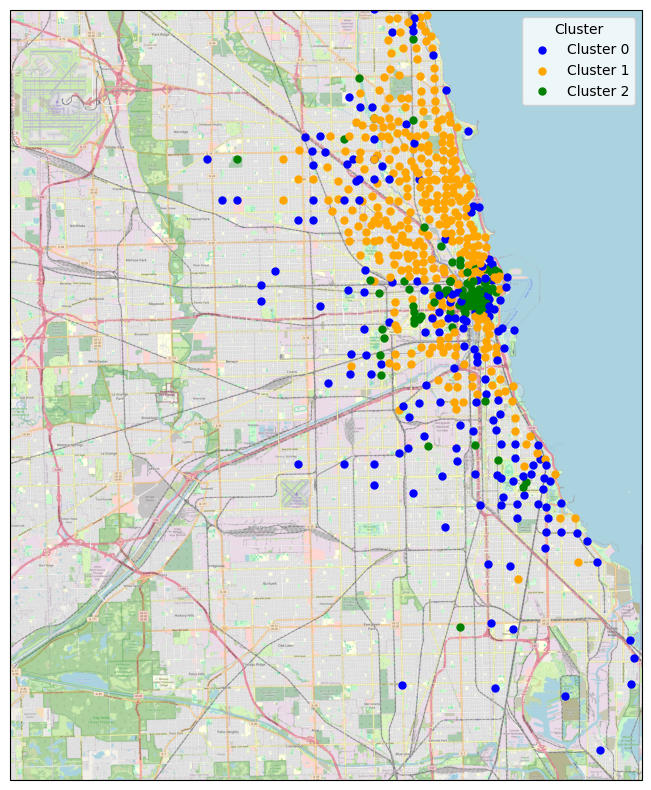

In [8]:
unique_stations = unique_stations.dropna(subset=['cluster'])
unique_stations['cluster'] = unique_stations['cluster'].astype(int)

# colors for clusters
colors = ['blue', 'orange', 'green',]

# create map and use OpenStreetMap for the backround map
def plot_cluster_map(data, title=''):
    osm = OSM()
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': osm.crs})  # Breiteres Layout

    # use same extent for all maps in thesis
    extent = [-87.9401, -87.5231, 41.6445, 42.0231]  # [west, east, south, north]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

   

    # create map background
    ax.add_image(osm, 13)  

    # plot every station
    for idx, row in data.iterrows():
        color = colors[row['cluster'] % len(colors)]
        ax.plot(row['end_lng'], row['end_lat'], 'o', color=color, markersize=5, transform=ccrs.Geodetic())

    # create the legends
    legend_elements = [
        plt.Line2D([], [], marker='o', color=colors[i], markersize=5, linestyle='', label=f'Cluster {i}')
        for i in range(len(colors))
    ]
    ax.legend(handles=legend_elements, loc='upper right', title="Cluster")

    plt.title(title)
    plt.show()

# plot map
plot_cluster_map(unique_stations)


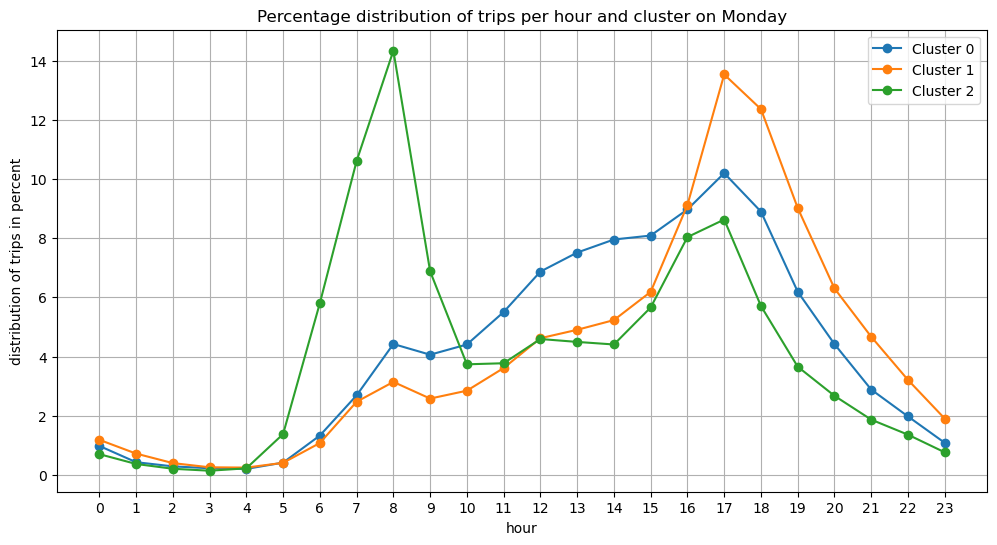

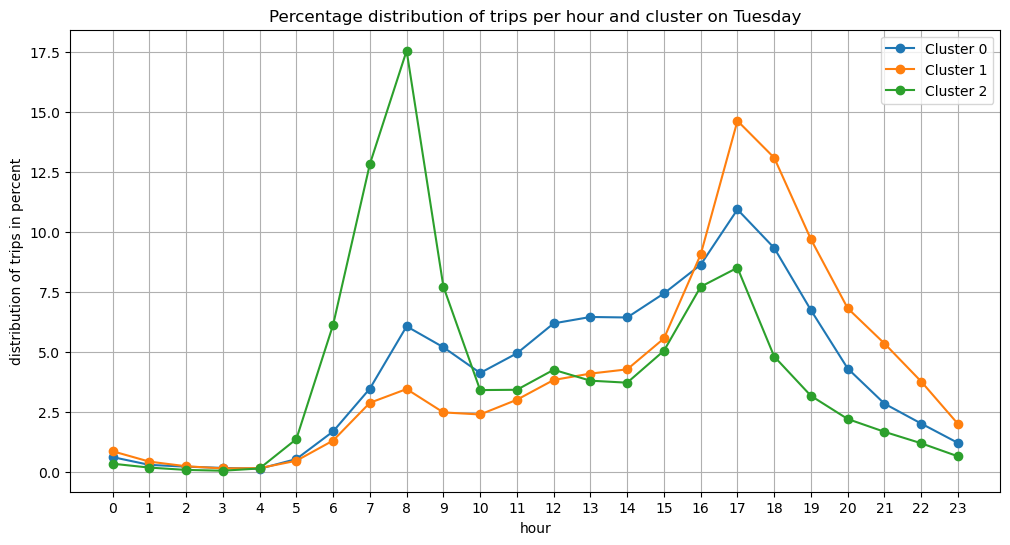

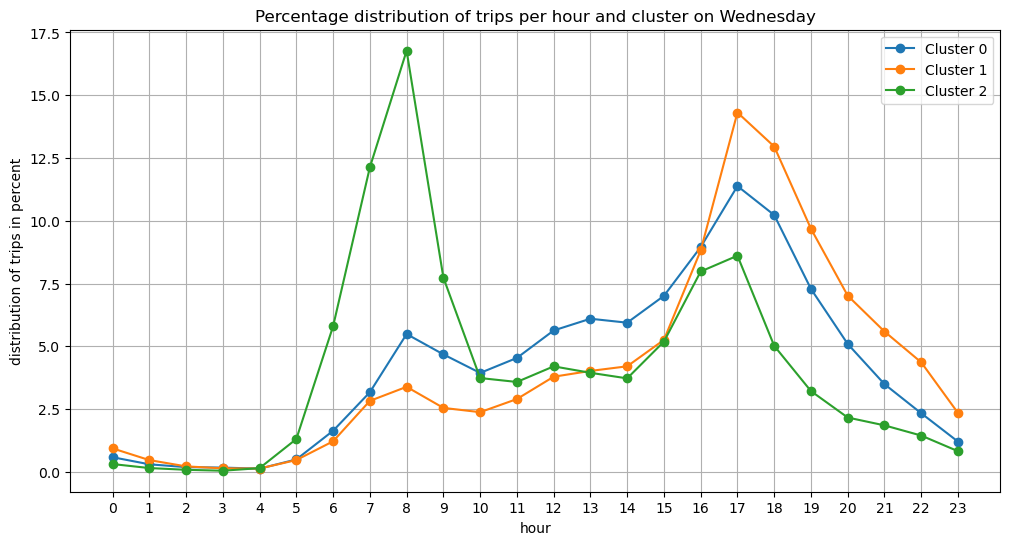

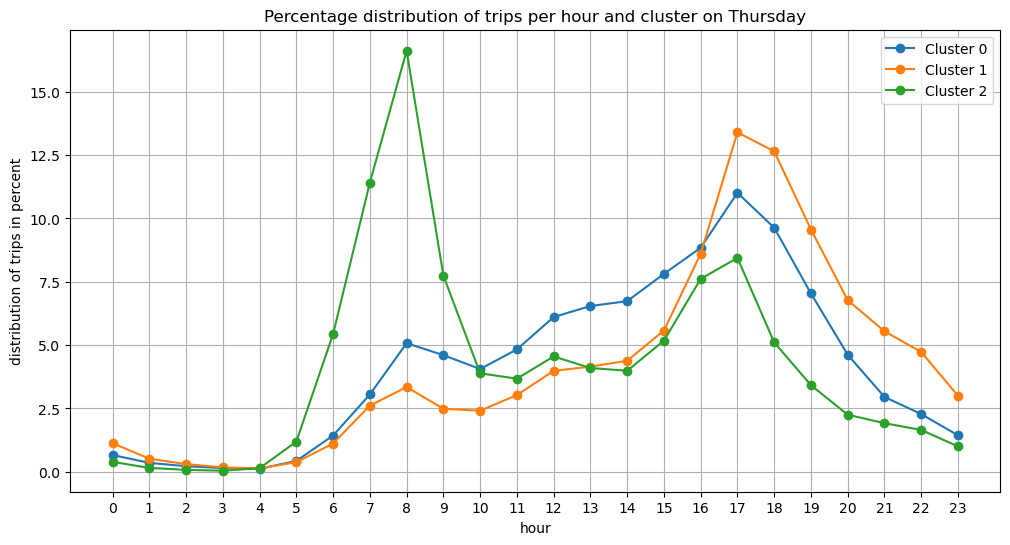

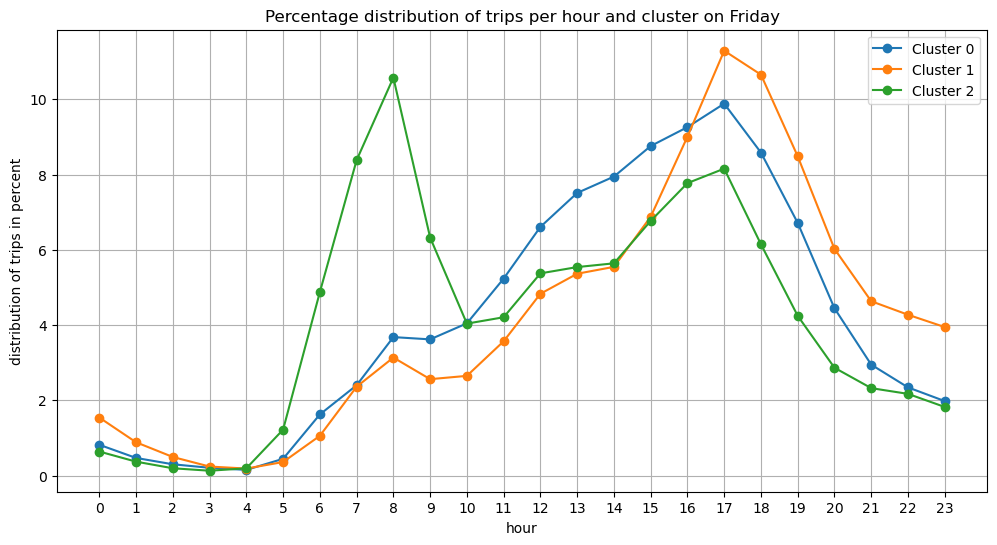

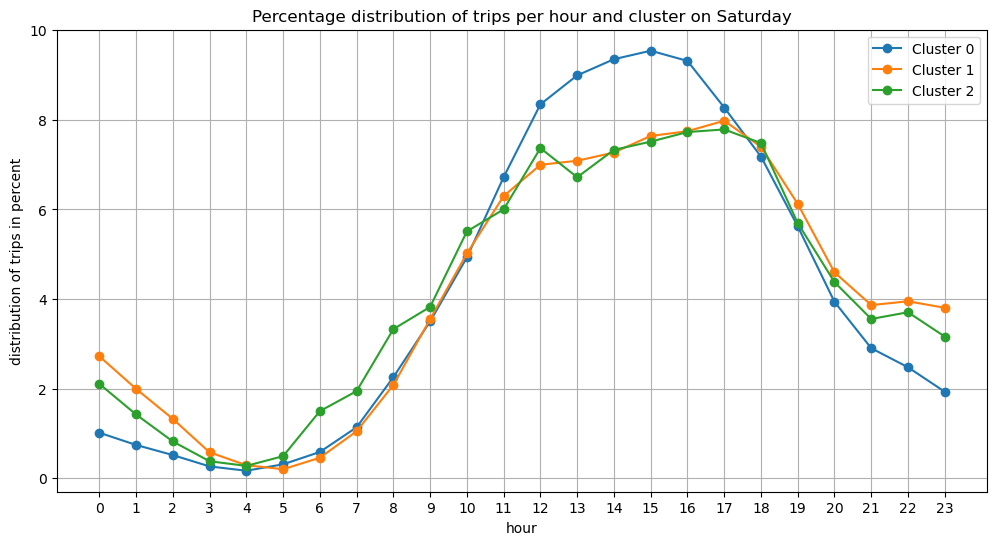

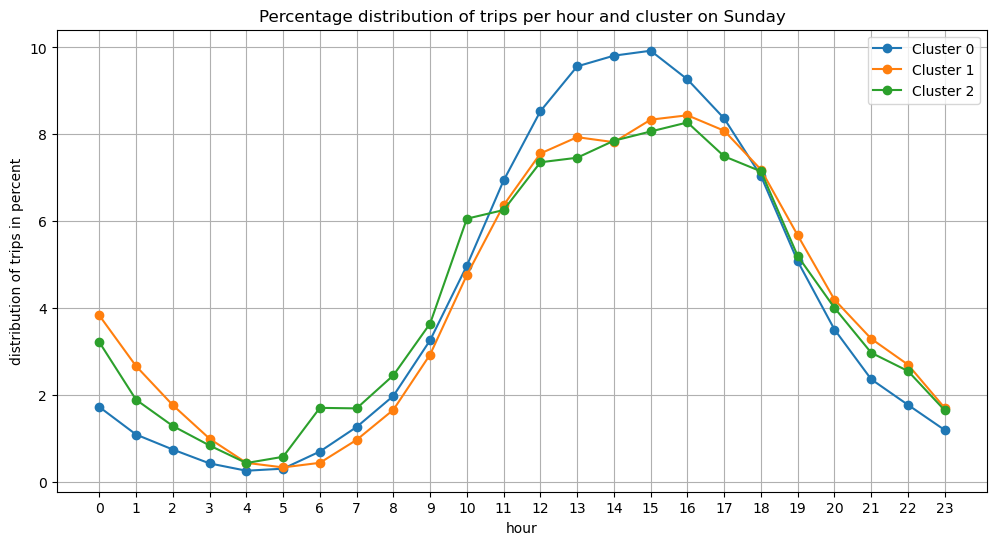

In [14]:
# create column hour and weekday
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['hour'] = df['ended_at'].dt.hour
df['weekday'] = df['ended_at'].dt.weekday

# get total count of trips per cluster and weekday
total_rides_cluster_weekday = df.groupby(['cluster', 'weekday']).ride_id.count().reset_index(name='total_cluster_weekday_rides')

# get hourly count of trips per hour, weekday and cluster
hourly_rides_cluster_weekday = df.groupby(['cluster', 'weekday', 'hour']).ride_id.count().reset_index(name='hourly_cluster_rides')

# merge these two dfs 
merged_rides = pd.merge(hourly_rides_cluster_weekday, total_rides_cluster_weekday, on=['cluster', 'weekday'])

# calculate the percentage of the hourly trips per cluster in relation to the daily trips per cluster
merged_rides['percentage'] = (merged_rides['hourly_cluster_rides'] / merged_rides['total_cluster_weekday_rides']) * 100

# conversion to a pivot table for simple plotting
pivot_data = merged_rides.pivot_table(index=['hour', 'weekday'], columns='cluster', values='percentage', fill_value=0)

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# plot the weekdays
for weekday in range(7): 
    plt.figure(figsize=(12, 6))
    for cluster in sorted(df['cluster'].unique()):
        if cluster in pivot_data.columns: 
            data_to_plot = pivot_data.xs(weekday, level='weekday')[cluster]
            plt.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}', marker='o')
        
    plt.title(f'Percentage distribution of trips per hour and cluster on {weekdays[weekday]}')
    plt.xlabel('hour')
    plt.ylabel('distribution of trips in percent')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(24)) 
    plt.show()

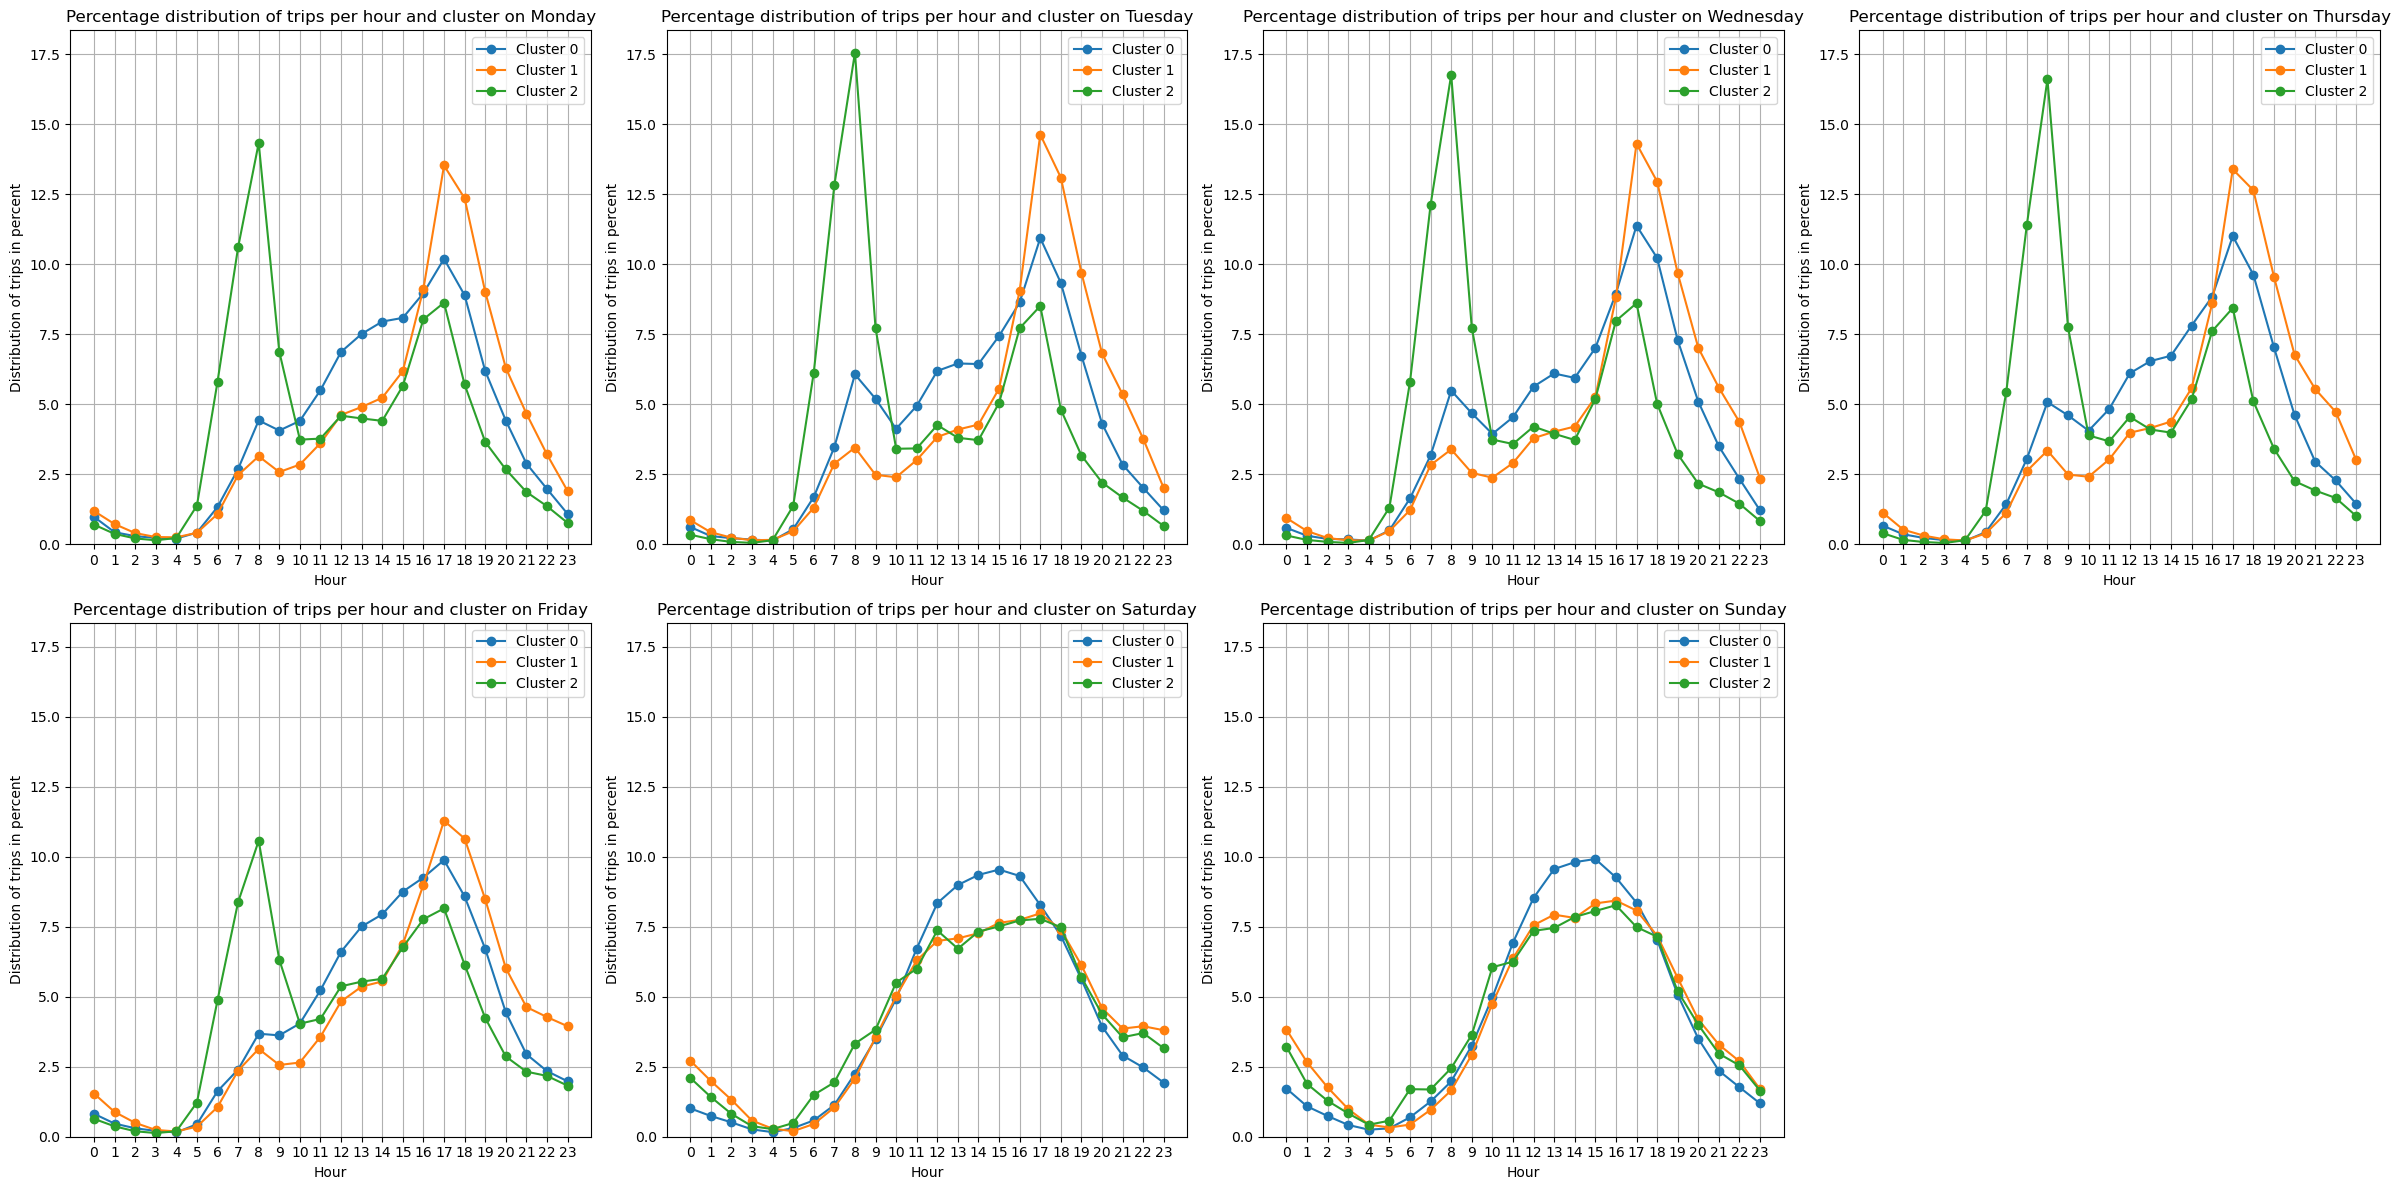

In [15]:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# create a figure and several axes for subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 12)) 

# find the max value to scale the y-axis
max_y = 0
for i in range(7):
    for cluster in sorted(df['cluster'].unique()):
        if cluster in pivot_data.columns:
            data_to_plot = pivot_data.xs(i, level='weekday')[cluster]
            max_y = max(max_y, data_to_plot.max()) +0.05

# Plot each day of the week in a separate subplot
for i, ax in enumerate(axes.flatten()[:7]): 
    for cluster in sorted(df['cluster'].unique()):
        if cluster in pivot_data.columns:
            data_to_plot = pivot_data.xs(i, level='weekday')[cluster]
            ax.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}', marker='o')

    # assign the correct weekday 
    ax.set_title(f'Percentage distribution of trips per hour and cluster on {weekdays[i]}')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Distribution of trips in percent')
    ax.legend()
    ax.grid(True)
    ax.set_xticks(np.arange(24))  
    ax.set_ylim(0, max_y)  

# delete the 8th subplot
axes[1, 3].axis('off')  

plt.tight_layout()  
plt.show()


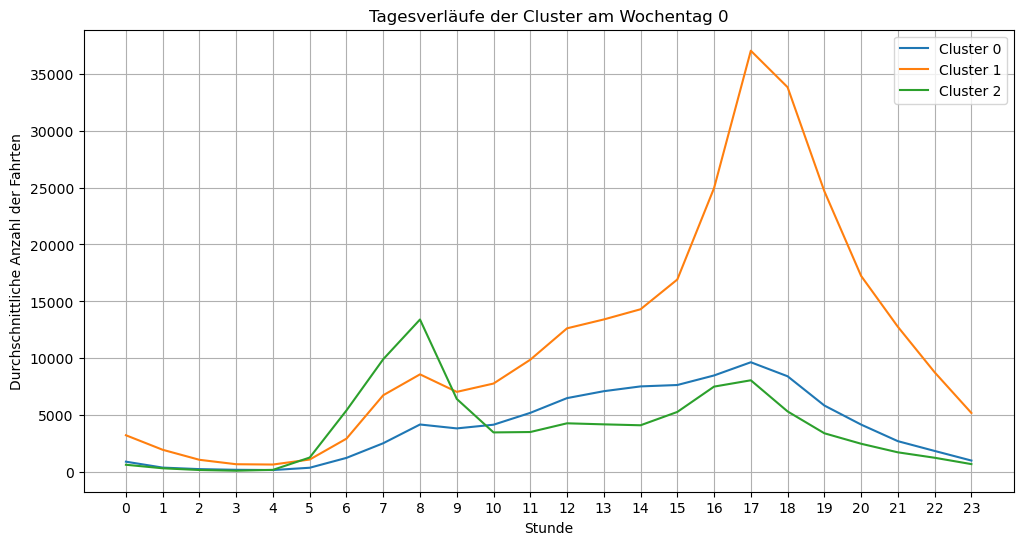

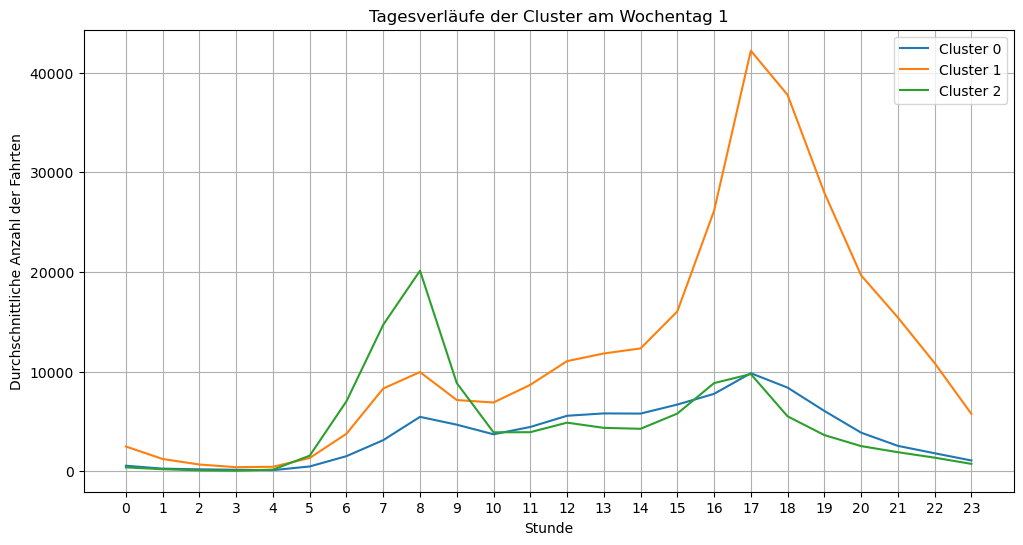

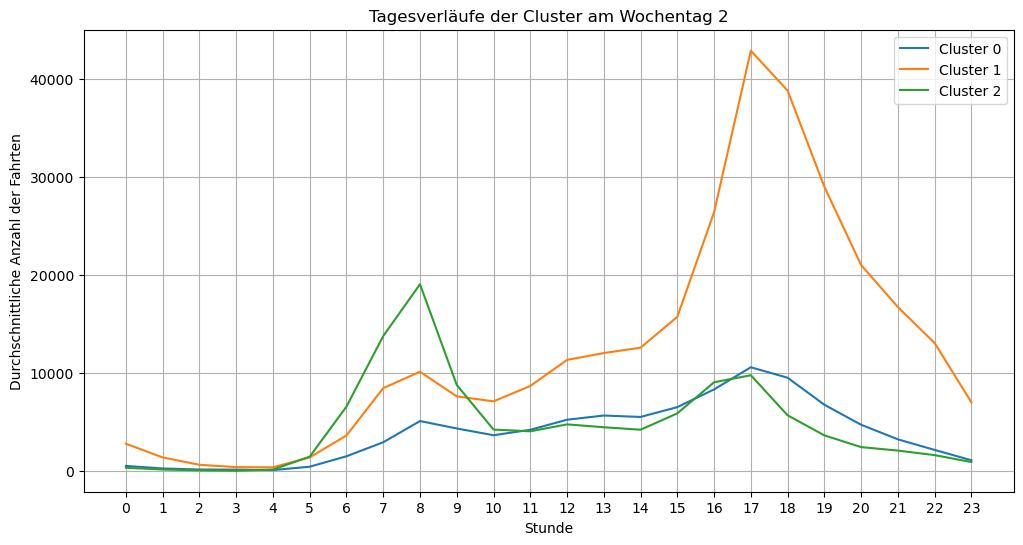

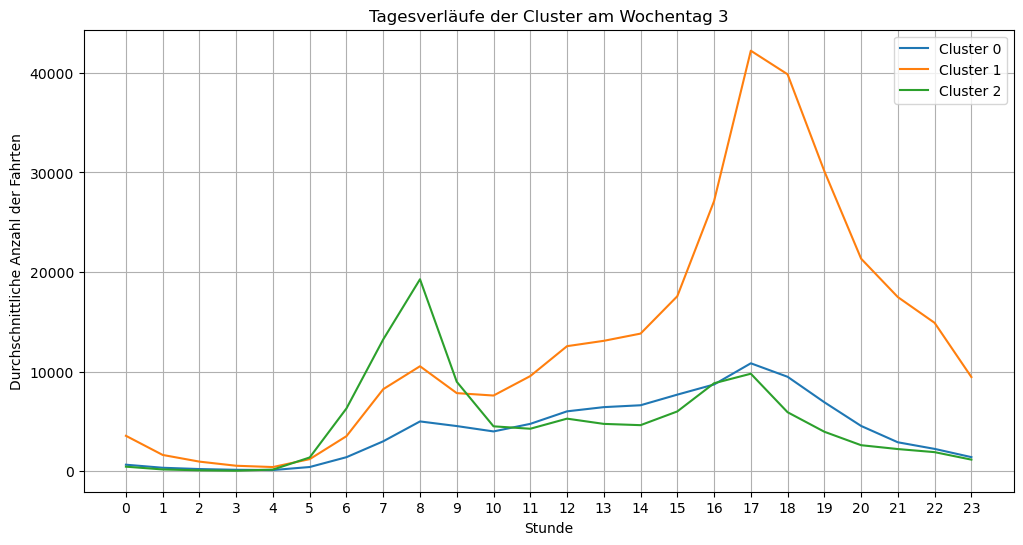

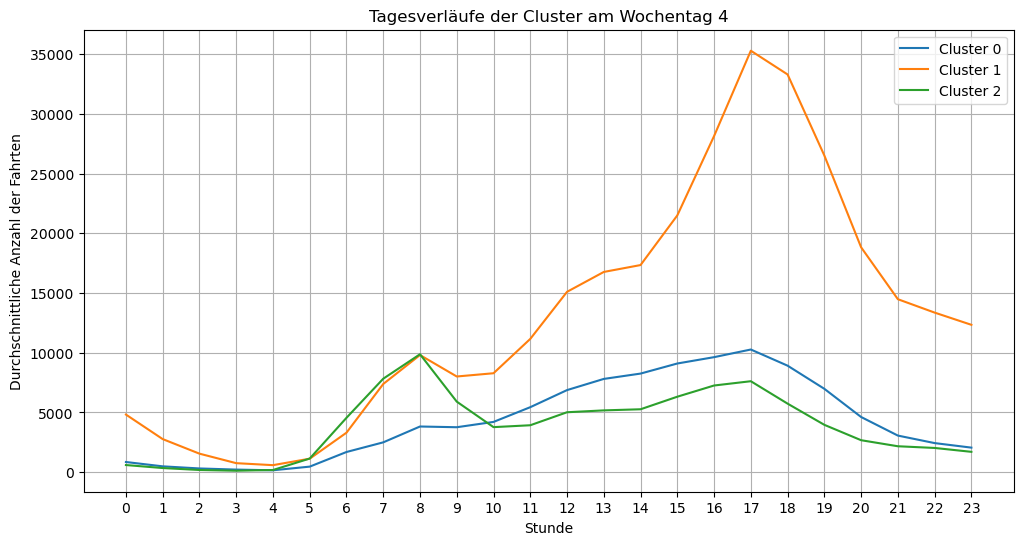

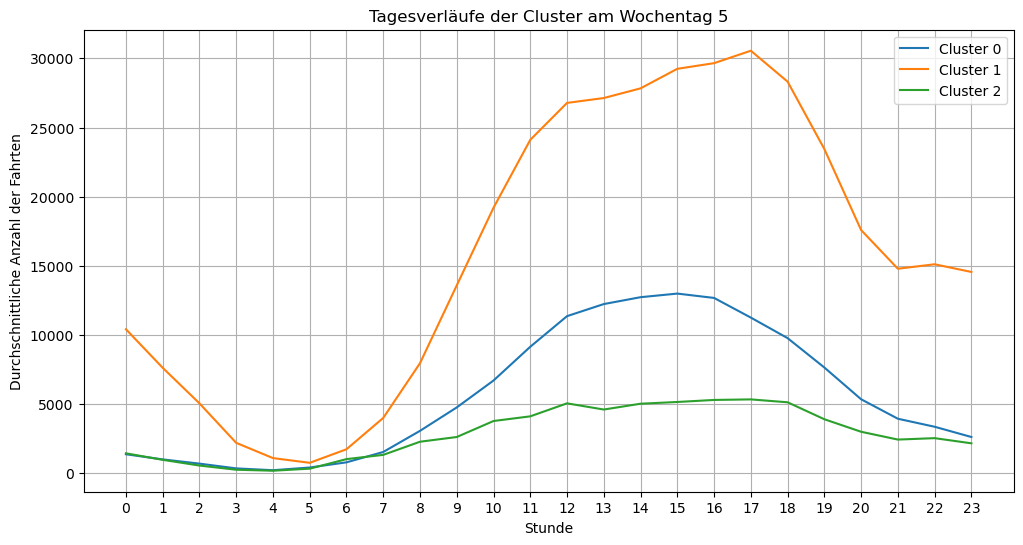

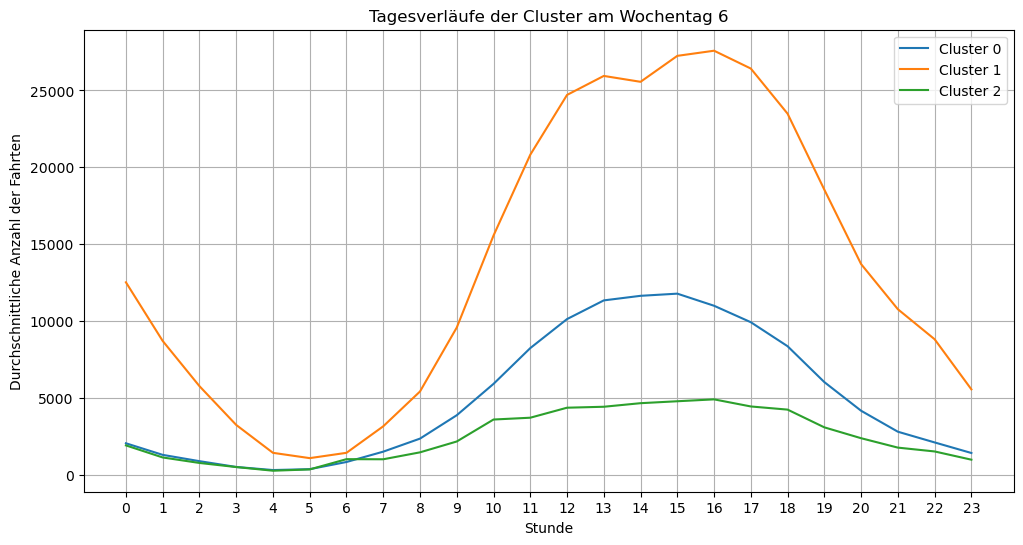

In [15]:
# now plot total trips of cluster per hour and weekday

df['ended_at'] = pd.to_datetime(df['ended_at'])
df['hour'] = df['ended_at'].dt.hour
df['weekday'] = df['ended_at'].dt.weekday

# aggregate the number of journeys per hour and day of the week for each cluster
agg_data = df.groupby(['cluster', 'weekday', 'hour']).ride_id.count().reset_index(name='ride_count')

# conversion to a pivot table for simple plotting
pivot_data = agg_data.pivot_table(index=['hour', 'weekday'], columns='cluster', values='ride_count', fill_value=0)

# plot each day of the week
for weekday in range(7):  
    plt.figure(figsize=(12, 6))
    for cluster in sorted(df['cluster'].unique()):
        data_to_plot = pivot_data.xs(weekday, level='weekday')[cluster]
        plt.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}')
        
    plt.title(f'Tagesverläufe der Cluster am Wochentag {weekday}')
    plt.xlabel('Stunde')
    plt.ylabel('Durchschnittliche Anzahl der Fahrten')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(24))  
    plt.show()

In [16]:
# aggregation of journeys per hour and weekday for each station
station_hour_weekday_counts = df.groupby(['end_station_id', 'weekday', 'hour'])['ride_id'].count().reset_index(name='ride_counts')

# conversion to a pivot table to create feature vectors for each station
pivot_df = station_hour_weekday_counts.pivot_table(index='end_station_id', columns=['weekday', 'hour'], values='ride_counts', fill_value=0)

# merge unique stations with pivot_df
pivot_df = pivot_df.merge(unique_stations[['end_station_id', 'cluster']], on='end_station_id')

# calculation of the average feature vector for each cluster
cluster_feature_vectors = pivot_df.groupby('cluster').mean()

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_2158/3842673609.py:8: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  pivot_df = pivot_df.merge(unique_stations[['end_station_id', 'cluster']], on='end_station_id')
/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_2158/3842673609.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_feature_vectors = pivot_df.groupby('cluster').mean()


In [17]:
# calculation of the cosine similiarity matrix
similarity_matrix = cosine_similarity(cluster_feature_vectors)

print(similarity_matrix)

[[1.         0.95579583 0.7781498 ]
 [0.95579583 1.         0.73430017]
 [0.7781498  0.73430017 1.        ]]
